In [ ]:
# References: The file vgg_feats.zip is provided by https://cs.stanford.edu/people/karpathy/deepimagesent/
# Which is a part of the paper "Deep Visual-Semantic Alignments for Generating Image Descriptions" by Andrej Karpathy and Li Fei-Fei


# Basic python libraries
import numpy as np
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
from collections import Counter

# DL libraries
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, concatenate, Reshape, Dropout, Conv2D, MaxPool2D, Flatten, Input, Multiply, Bidirectional, BatchNormalization
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.models import load_model, Model
from tensorflow.keras.applications import VGG16

# Helper libraries
from scipy import io
import h5py
import pickle

# NLP libraries
from nltk import word_tokenize
import nltk
nltk.download('punkt')

# Load data
drive.mount('/content/drive')
!unzip /content/drive/MyDrive/glove.zip -d /content
!unzip /content/drive/MyDrive/cocoqa-2015-05-17.zip -d /content
!unzip /content/drive/MyDrive/vgg_feats.zip -d /content
!unzip /content/drive/MyDrive/train2014.zip -d /content/train2014
!unzip /content/drive/MyDrive/vgg16_weights.zip -d /content/weights

In [2]:
# Read a file line by line and convert it into a numpy array of a specified type
def read_file(path, dtype):
    return np.asarray([line.strip() for line in open(path)], dtype=dtype)

# Create a DataFrame from files in a given folder, with columns for image IDs, types, questions, and answers
def create_dataframe(folder):
    return pd.DataFrame({
        'image_id': read_file(str(folder) + '/img_ids.txt', 'int64'),
        'type': read_file(str(folder) + '/types.txt', 'int8'),
        'question': read_file(str(folder) + '/questions.txt', 'str'),
        'answer': read_file(str(folder) + '/answers.txt', 'str')
    })

In [3]:
# Try to create a directory for preprocessing, ignore if it already exists
try:
    os.makedirs('preprocessing/COCO-QA')
except:
    pass

# Try to create a directory for top answers, ignore if it already exists
try:
    os.makedirs('answers_dir')
except:
    pass

# Try to create a directory for embeddings, ignore if it already exists
try:
    os.makedirs('mat_saves/')
except:
    pass

# Try to create a directory for storing model weights, ignore if it already exists
try:
    os.makedirs('model_weights/')
except:
    pass

In [4]:
# Load training and validation data into DataFrame from specified paths
train_data = create_dataframe('/content/train')
val_data = create_dataframe('/content/test')

In [5]:
#xtracts VGG features for the images specified in the data
def get_feat(database):
    # Read coco to the vgg mapping file to get map of vgg index and coco images
    img_ids = open('/content/coco_vgg_IDMap.txt').read().splitlines()
    id_map = {int(ids.split()[0]): int(ids.split()[1]) for ids in img_ids}

    # get features for images using id map
    VGGfeatures = io.loadmat('/content/vgg_feats.mat')['feats']
    return np.array([VGGfeatures[:, id_map[img_id]] for img_id in database['image_id'].tolist()])

In [6]:
# Define an LSTM model for VQA with pre-trained embeddings
def lstm_model(num_classes, embedding_matrix):

    # Define inputs: one for text and one for image features
    text_input = Input(shape=(None,))
    image_input = Input(shape=(4096,))

    # Embedding layer using pre-trained embeddings, set to non-trainable
    embedding_layer = Embedding(
        input_dim = embedding_matrix.shape[0],
        output_dim = embedding_matrix.shape[1],
        weights = [embedding_matrix],
        trainable = False
    )(text_input)

    # LSTM layer to process the embedded text, capturing hidden and cell states
    _, hidden_state, cell_state = LSTM(512, return_state=True)(embedding_layer)

    # Combine the LSTM outputs with the image features, followed by dense layers and dropout for regularization
    x = Multiply()([concatenate([cell_state, hidden_state]), Dense(units=1024, activation='tanh')(image_input)])
    x = Dropout(0.5)(x)
    x = Dense(1000, activation='tanh')(x)
    x = Dropout(0.5)(x)
    # Output layer with softmax activation for classification
    x = Dense(num_classes, activation='softmax')(x)

    # Construct the model with image and text inputs
    return Model(inputs = [image_input, text_input], outputs = x)

In [7]:
# Combine answers from train and validation sets, and count occurrences of each unique answer
answers = list(train_data['answer']) + list(val_data['answer'])

counts = {}
# Count the frequency of each answer, converting them to lowercase for consistency
for ans in answers:
    if ans.lower() in counts:
        counts[ans.lower()] += 1
    else:
        counts[ans.lower()] = 1

# Select the top 1000 most frequent answers
bestAnswers = [word for word, j in sorted(counts.items(), key=lambda value: value[1], reverse=True)[:1000]]

In [8]:
# Write the top answers to a file
with open('answers_dir/mode_answers.txt', 'w') as f:
    results = '\n'.join(bestAnswers)
    f.write(results)

# Create a dictionary mapping top answers to their indices
map1 = dict(zip(bestAnswers, range(len(bestAnswers))))
# Filter the train and validation datasets to only include data with top answers
preprocessed_train = train_data.iloc[[i for i, ans in enumerate(train_data['answer']) if ans in map1]]
preprocessed_val = val_data.iloc[[i for i, ans in enumerate(val_data['answer']) if ans in map1]]

In [9]:
# Tokenize and lower-case questions from the filtered train and validation sets, and count word occurrences
words = [word for q in (preprocessed_train['question'].tolist() + (preprocessed_val['question'].tolist() if preprocessed_val.size != 0 else [])) for word in word_tokenize(q.lower())]
counts = Counter(words)
# Create a vocabulary of words present in the questions
vocab = [word for word, count in counts.items() if count > 0]
# Assign an index to each word in the vocabulary
word_idx = {word: idx+1 for idx, word in enumerate(vocab)}

# Create an embedding matrix for the vocabulary, initializing with zeros
embedding_matrix = np.zeros((len(vocab) + 1, 300))
# Load GloVe embeddings and assign them to the respective words in the vocabulary
with open('/content/glove.6B/glove.6B.300d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        if values[0] in word_idx:
            embedding_matrix[word_idx[values[0]]] = np.asarray(values[1:], dtype='float32')

# Save the word to index mapping for future use
with open('mat_saves/word_idx','wb') as f:
    pickle.dump(word_idx,f)

In [10]:
# Convert questions from the filtered train and validation sets to sequences of indices, padding where necessary
q_train = pad_sequences([[word_idx.get(word, 0) for word in word_tokenize(q.lower())] for q in preprocessed_train['question']])
q_val = pad_sequences([[word_idx.get(word, 0) for word in word_tokenize(q.lower())] for q in preprocessed_val['question']])

# Create a dictionary to convert answers to one-hot encoded vectors based on the number of top answers
encoded_dictionary = {ans: np.eye(len(bestAnswers))[i] for i, ans in enumerate(bestAnswers)}

# Convert answers in the filtered train and validation datasets to one-hot encoded vectors
answers_train = np.array([encoded_dictionary[ans.lower()] for ans in preprocessed_train['answer']])
answers_val = np.array([encoded_dictionary[ans.lower()] for ans in preprocessed_val['answer']])

# Extract image features for the training and validation datasets
img_features_train = get_feat(preprocessed_train)
img_features_val = get_feat(preprocessed_val)

In [11]:
# Initialize the LSTM model with the number of answer classes, vocabulary size, and embedding matrix
model = lstm_model(num_classes=len(bestAnswers), embedding_matrix=embedding_matrix)
# Compile the model with the Adam optimizer and categorical crossentropy as the loss function
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Train the model on the training data and validate on the validation data
model.fit([img_features_train, q_train],answers_train, epochs=10, batch_size=128, validation_data=([img_features_val, q_val],answers_val), verbose=1)
# Save the trained model weights
model.save('model_weights/lstm_coco.h5')

Epoch 1/10
616/616 [==============================] - 16s 13ms/step - loss: 2.7847 - accuracy: 0.3657 - val_loss: 2.0416 - val_accuracy: 0.4879
Epoch 2/10
616/616 [==============================] - 6s 9ms/step - loss: 2.0611 - accuracy: 0.4765 - val_loss: 1.8416 - val_accuracy: 0.5250
Epoch 3/10
616/616 [==============================] - 6s 9ms/step - loss: 1.8548 - accuracy: 0.5128 - val_loss: 1.7877 - val_accuracy: 0.5284
Epoch 4/10
616/616 [==============================] - 6s 9ms/step - loss: 1.7270 - accuracy: 0.5361 - val_loss: 1.7355 - val_accuracy: 0.5421
Epoch 5/10
616/616 [==============================] - 6s 9ms/step - loss: 1.6142 - accuracy: 0.5583 - val_loss: 1.7079 - val_accuracy: 0.5524
Epoch 6/10
616/616 [==============================] - 6s 9ms/step - loss: 1.5446 - accuracy: 0.5699 - val_loss: 1.7143 - val_accuracy: 0.5556
Epoch 7/10
616/616 [==============================] - 6s 9ms/step - loss: 1.4672 - accuracy: 0.5873 - val_loss: 1.7211 - val_accuracy: 0.5539
Epoc

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
# Define a function to get the top 5 predicted answers for a given image and question
def get_answer(img_path, question):

    # Load the list of top answer classes and word-to-index mapping
    with open('answers_dir/mode_answers.txt', 'r') as f:
        top_answers_classes = [line.strip() for line in f]

    with open('mat_saves/word_idx', 'rb') as f:
        word_idx = pickle.load(f)

    # Load pre-trained VGG16 model and create a model to extract features from the last FC layer
    vgg_model = VGG16(weights='imagenet', include_top=True)
    features_model = Model(inputs=vgg_model.input, outputs=vgg_model.layers[-1].input)

    # Preprocess the input image and extract features
    feature_list = [preprocess_input(np.expand_dims(image.img_to_array(image.load_img(img_path, target_size=(224, 224))), axis=0))]
    img_features = features_model([feature_list], training=False)

    # Tokenize and encode the question
    tok_list = word_tokenize(question.lower())
    question_sequence = np.reshape([word_idx.get(token, 0) for token in tok_list], (1, len(tok_list)))

    # Load the trained LSTM model and predict the answer
    loaded_model = load_model('model_weights/lstm_coco.h5')
    answers_ids = np.argsort(loaded_model.predict([img_features, question_sequence])[0])[::-1]

    # Return the top 5 predicted answers
    return [top_answers_classes[answers_ids[i]] for i in range(5)]

1/1 [==============================] - 0s 427ms/step


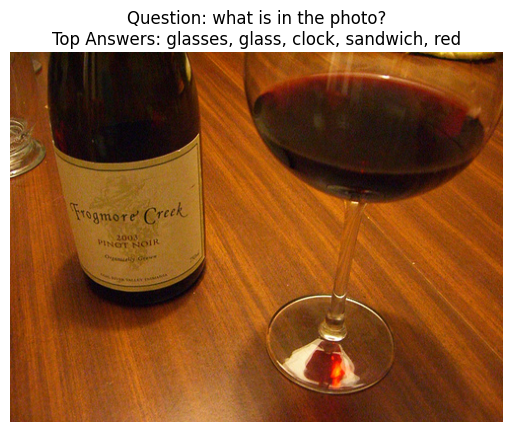

In [13]:
# Example usage of the function
image_path = '/content/train2014/train2014/COCO_train2014_000000485465.jpg'
question = 'what is in the photo?'

# Display the image with the question and top answers
img = plt.imread(image_path)
plt.imshow(img)
plt.axis('off')
plt.title(f"Question: {question}\nTop Answers: {', '.join(get_answer(image_path, question))}")
plt.show()